# Модельная реализация алгоритма JPEG

В этой задаче мы реализуем "игрушечную" версию алгоритма сжатия с потерями [JPEG](https://en.wikipedia.org/wiki/JPEG).  В общих чертах мы хотим сделать следующее:
1. Преобразовать (чёрно-белую) картинку в 4-мерный массив с размерами `t x n x 8 x 8`. Последние два измерения отвечают блокам 8 x 8 пикселей. Первое измерение техническое и нужно для последующего распараллеливания.
2. Применить двумерное дискретное косинусное преобразование к каждому блоку.
3. Дискретизовать каждый блок в соответствии с матрицей дискретизации $Q$, то есть поэлементно разделить блок на $Q$ и взять ближайшее целое число к каждому элементу.

Обратное преобразование делается симметрично. Также мы вычислим примерное количество байт, необходимое, чтобы хранить сжатое изображение. Для этого мы:
1. Выпишем дискретизованные значения в каждом блоке в линию в "зигзагообразном порядке" (см. [Википедию](https://en.wikipedia.org/wiki/JPEG#Entropy_coding)).
2. Отбросим нули в конце.
3. Для каждого оставшегося элемента $x$ выделим $\lceil\log_2(|x|+1)\rceil + 1$ бит (таким образом, число 0 будет кодироваться 1 битом, числа $x\in\{-1,0,1\}$ — двумя и т.д.). Это грубая оценка. Понятно, что "в лоб" закодировать таким количеством бит не получится из-за переменной длины. С другой стороны, вероятно, можно закодировать даже короче, используя энтропийное кодирование типа [арифметического](https://ru.wikipedia.org/wiki/%D0%90%D1%80%D0%B8%D1%84%D0%BC%D0%B5%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5).
4. Сложим количество бит по всем блокам.

Также мы попробуем запустить описанный алгоритм на [TPU](https://en.wikipedia.org/wiki/Tensor_Processing_Unit) с помощью библиотеки [JAX](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html).


In [1]:
import io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

(256, 256)


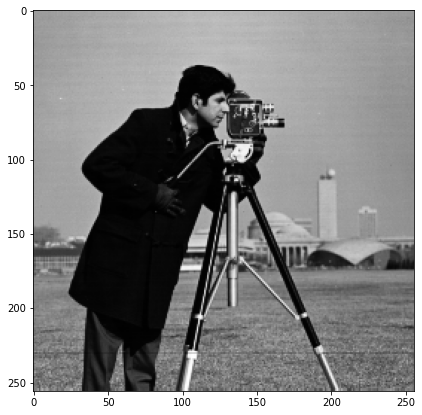

In [2]:
im = imread('cameraman.tif').astype(np.float)
print(im.shape)
plt.figure(figsize=(7,7))
_ = plt.imshow(im, cmap='gray')

## 1. Преобразование картинки в 4-мерный массив и обратно

a. **(6 баллов)** Заполните пропуски в функции `im_to_array`. Она принимает на вход чёрно-белую картинку (массив) размера `m x n` с элементами типа `np.uint8` и возвращает массив `X` размеров `num_tpus x blocks_per_tpu x block_size x block_size`, где `blocks_per_tpu == m * n / (num_tpus * block_size * block_size)`.

Для этого нарежьте картинку на блоки `block_size x block_size`, после чего занумеруйте все блоки в Си-порядке, то есть вот так:
```
0  1  2  3
4  5  6  7
8  9  10 11
12 13 14 15
```
Первому [TPU](https://en.wikipedia.org/wiki/Tensor_Processing_Unit) будет отвечать первый отрезок размера `blocks_per_tpu`, то есть блоки `0, 1, ..., blocks_per_tpu - 1`, второму — следующий отрезок и т.д.
Например, для примера выше (с 16-ю блоками) в случае двух TPU первые две блочные строки соответствуют первому TPU, а третья и четвёртая — второму.

**Рекомендуем везде в этом задании использовать Си-порядок при решейпах (`order="C"`, он же дефолтный).**

In [3]:
# source: https://question-it.com/questions/1395868/kak-razbit-matritsu-na-4-bloka-ispolzuja-numpy
def split(np, array, block_size):
    m, n = array.shape
    array = np.reshape(array, (n // block_size, block_size, -1, block_size))
    array = array.swapaxes(1, 2)
    array = np.reshape(array, (-1, block_size, block_size))

    return array

In [4]:
def im_to_array(np, im, block_size, num_tpus):
    m, n = im.shape
    assert m % block_size == 0
    assert n % block_size == 0

    X = split(np, im, block_size)
    blocks_per_tpu = m * n // (num_tpus * block_size * block_size)
    X = np.reshape(X, (num_tpus, blocks_per_tpu, block_size, block_size))

    return X

Проверим, что функция работает. Для этого возьмём блоки размером 32 x 32 и нарисуем их.
Должна получиться исходная картинка, нарезанная на кусочки.

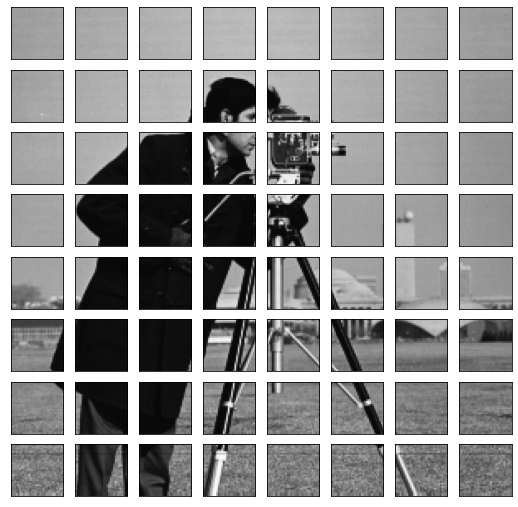

In [5]:
X = im_to_array(np, im, 32, 8)
assert X.shape == (8, 8, 32, 32)

fig, axs = plt.subplots(8, 8, subplot_kw={'xticks': [], 'yticks': []}, figsize=(9,9))
for i in range(8):
    for j in range(8):
        axs[i,j].imshow(X[i,j,:,:], cmap="gray", vmin=0, vmax=255)

b. **(6 баллов)** Напишите функцию обратного преобразования четырёхмерного массива в картинку. **Подсказка.** Вы можете воспользоваться обратимостью функции `np.reshape`: `np.reshape(np.reshape(X, s), X.shape) == X`. Похожее утверждение верно для функции `np.transpose`.

In [6]:
def array_to_im(np, X, m, n):
    num_tpus, blocks_per_tpu, block_size = X.shape[:3]
    assert np.prod(X.shape) == m * n
    assert m % block_size == 0
    assert n % block_size == 0    

    X = np.reshape(X, (num_tpus * blocks_per_tpu, block_size, block_size))
    blocks_on_side = m // block_size

    X = np.reshape(X, (n // block_size, -1, block_size, block_size))
    X = X.swapaxes(1, 2)
    X = np.reshape(X, (m, n))
    
    return X

Сделаем проверку.

In [7]:
X = im_to_array(np, im, 8, 8)
assert np.all(array_to_im(np, X, *im.shape) == im)

## 2. Другие вспомогательные функции

a. **(5 баллов)** Напишите функцию `create_DCT2_matrix`, принимающую натуральное число `n` и возвращающую матрицу дискретного косинусного преобразования второго типа ([википедия](https://en.wikipedia.org/wiki/Discrete_cosine_transform#DCT-II)) размера `n x n`.

In [8]:
import math
def create_DCT2_matrix(np, n):
    
    J, I = np.meshgrid(np.arange(n), np.arange(n))
    CS = np.cos(math.pi / n * (J + 0.5) * I)
    
    t = np.eye(n, dtype=np.float64)
    t[0, 0] = 1 / math.sqrt(2)
    
    return t @ CS * math.sqrt(2 / n)  

Сделаем проверку.

In [9]:
A1 = create_DCT2_matrix(np, 1)
assert np.linalg.norm(A1 - 1) < 1e-9
A2 = create_DCT2_matrix(np, 2)
assert np.linalg.norm(A2 - np.cos(np.pi/4) * np.array([[1, 1], [1, -1]])) < 1e-9

# DCT matrix must be orthogonal.
A7 = create_DCT2_matrix(np, 7)
assert np.linalg.norm(A7 @ A7.T - np.eye(7)) < 1e-9

b. **(7 баллов)** Заполните пропуски в функции `compute_bit_size_truncated`, вычисляющей битовый размера сжатого представления.

In [10]:
def compute_bit_size_truncated(np, M):
    # Вычислите булев массив mask, содержащий значения True в тех и только тех элементах,
    # которые лежат до (включительно) последнего ненулевого элемента
    # Если массив M многомерный, примените указанное преобразование вдоль последней оси.
    # Подcказка: вам пригодится функция np.cumsum
    # (если указывать axis=-1, она будет действовать как раз вдоль последней оси).
    # Для массива M = [[1,0,2,0],[0,1,0,0]] ожидается, что mask == [[1,1,1,0],[1,1,0,0]]
  
    cus = np.cumsum(M, axis=(M.ndim - 1))
    # print(cus)
    AMAX = np.amax(cus, axis=(M.ndim - 1), keepdims=True)
    cus -= AMAX
    mask = cus.astype(bool)
    # print(cus)
    mask += np.roll(mask, 1, axis=(M.ndim - 1))
    
    # Вычислим количество бит для хранения каждого числа.
    # Мотивацию формулы см. в первом разделе.
    bits = np.ceil(np.log2(np.abs(M) + 1)) + 1
    return np.sum(bits * mask)

Сделаем проверку.

In [11]:
a1 = np.array([1,2,0,0,0])
a2 = np.array([[1,0,1,0,0], [1,0,2,0,0]])
a3 = np.array([
    [[1,1,0,0], [1,2,0,0]],
    [[1,1,0,0], [1,2,0,0]],
])

assert 5 == compute_bit_size_truncated(np, a1)
assert 11 == compute_bit_size_truncated(np, a2)
assert 18 == compute_bit_size_truncated(np, a3)

Прежде чем реализовать нашу упрощённую версию JPEG-сжатия, нам потребуется ещё два ингредиента:
1. Функция, умеющая создавать матрицу квантизации.
2. Массив `ZIGZAG_IDX`, который позволит нам вытягивать пиксели блока в линию (чтобы затем обрезать нули).

In [12]:
def create_quantization_matrix(np, quality):
    quality = float(quality)
    assert 1 <= quality <= 100

    Tb = np.loadtxt(io.StringIO("""
        16    11    10    16    24    40    51    61
        12    12    14    19    26    58    60    55
        14    13    16    24    40    57    69    56
        14    17    22    29    51    87    80    62
        18    22    37    56    68   109   103    77
        24    35    55    64    81   104   113    92
        49    64    78    87   103   121   120   101
        72    92    95    98   112   100   103    99
    """), dtype=np.float64)

    if quality < 50:
        S = 5000 / quality
    else:
        S = 200 - 2 * quality

    Ts = np.floor((S * Tb + 50) / 100)
    Ts[Ts == 0] = 1
    return Ts

In [13]:
ZIGZAG_IDX = np.array([
        [0,  1,  5,  6,  14, 15, 27, 28],
        [2,  4,  7,  13, 16, 26, 29, 42],
        [3,  8,  12, 17, 25, 30, 41, 43],
        [9,  11, 18, 24, 31, 40, 44, 53],
        [10, 19, 23, 32, 39, 45, 52, 54],
        [20, 22, 33, 38, 46, 51, 55, 60],
        [21, 34, 37, 47, 50, 56, 59, 61],
        [35, 36, 48, 49, 57, 58, 62, 63]
    ]).ravel()

## 3. Сжатие

a. **(11 баллов)** Теперь мы готовы собрать нашу упрощённую версию JPEG-сжатия. Заполните пропуски в функции `compress_and_decompress_impl`. Функция принимает, в частности, многомерный (3- или 4-мерный) массив `X`, матрицу дискретного косинусного преобразования `A`, матрицу квантизации `Q` и массив с зигзагообразным порядком индексов `zigzag_idx`. Возвращает эта функция массив `restored_X`, соответствующий картинке, восстановленной после квантизации, а также размер сжатого представления в байтах.

In [31]:
def compress_and_decompress_impl(np, X, A, Q, zigzag_idx):
    # Выполните двумерное косинусное преобразование для каждого блока
    dims = X.ndim
    sh = X.shape
    if (dims == 3):
        X = np.reshape(X, (1, *X.shape))
    
    # y[ij] = sum_{kl}(a[k] x[ij, kl] a.t[l]) - y[ij] - это блок, x -> y
    dct = np.einsum("ik,abkd,dj->abij", A, X, A.T, optimize='optimal') # A.T так как A.T[k] - столбец, A[k] - строка
    
    # Квантизуйте преобразованные блоки с помощью матрицы квантизации Q.
    # Используйте округление к ближайшему целому. (rint)
    quantized = np.rint(dct / Q)
  
    # Вычислим массив M, в которой последнее измерение имеет размер (block_size * block_size),
    # и содержит интенсивности (в частотном домене) пикселей блока,
    # расположенные в зигзагообразном порядке.
    s = quantized.shape
    M = np.reshape(quantized, s[:-2] + (s[-2] * s[-1],))[:, zigzag_idx]

    size_bits = compute_bit_size_truncated(np, M)

    # "Расквантизуйте" косинусное представление.
    restored_dct = quantized * Q

    # Выполните обратное двумерное косинусное преобразование.
    restored_X = np.einsum("ik,abkd,dj->abij", A.T, restored_dct, A, optimize='optimal')
    # restored_X = np.reshape(restored_X, sh)

    # Возвращаем количество байт и разжатое изображение.
    return np.ceil(size_bits / 8), restored_X

Теперь мы готовы собрать функцию `compress_and_decompress`, более удобную для использования.

In [32]:
def compress_and_decompress(np, im, quality, block_size, num_tpus, zigzag_idx):
    # Сформируем матрицу двумерного косинусного преобразования.
    A = create_DCT2_matrix(np, block_size)
    
    # Преобразуем картинку в 4-мерный массив.
    X = im_to_array(np, im, block_size, num_tpus)
    
    # Сформируем матрицу квантизации для заданного уровня качества.
    Q = create_quantization_matrix(np, quality)
    
    size_bytes, restored_X = compress_and_decompress_impl(np, X, A, Q, zigzag_idx)
    
    # Восстановим изображение обратно из 4-мерного массива.
    restored_im = array_to_im(np, restored_X, *im.shape)

    # Возвращаем количество байт и разжатое изображение.
    return size_bytes, restored_im

Проверим корректность на глаз. При уменьшении параметра `quality` видимое качество картинки должно уменьшаться, также должны возникать артефакты сжатия. Количество байт в сжатом представлении тоже должно уменьшаться.

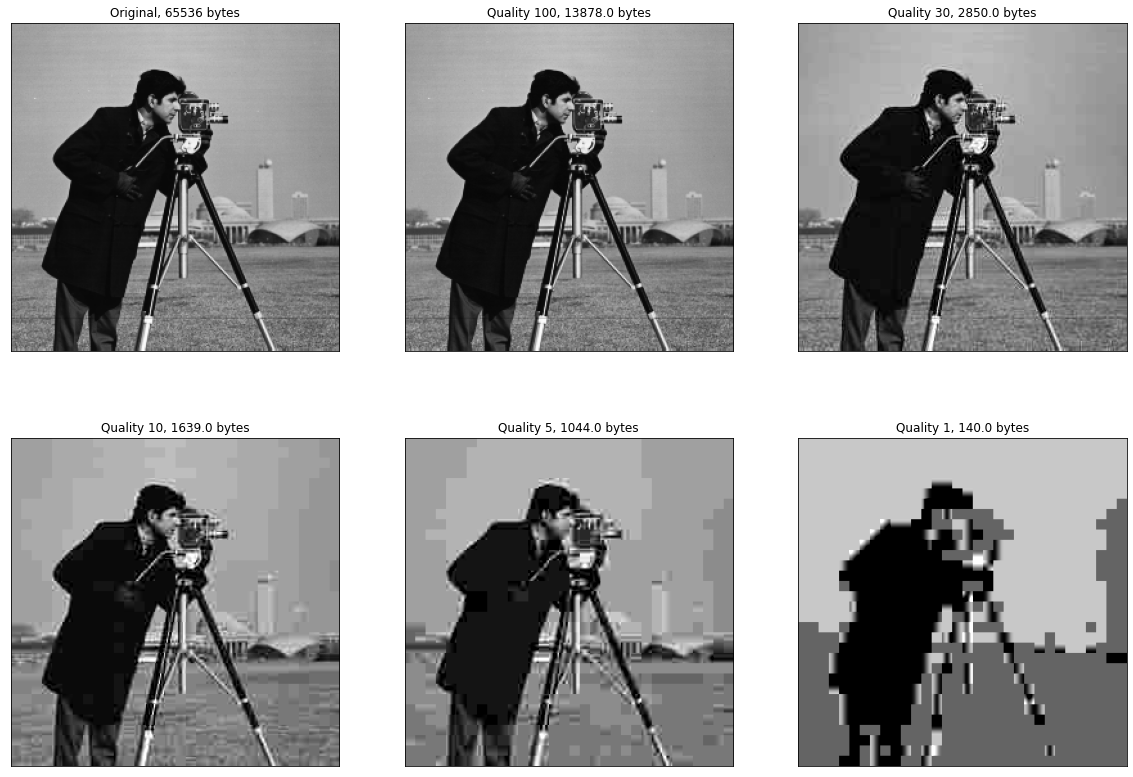

In [33]:
BLOCK_SIZE = 8
NUM_TPUS = 8

qualities = [
  [None, 100, 30],
  [10, 5, 1],
]

fig, axes = plt.subplots(2, 3, subplot_kw={'xticks': [], 'yticks': []}, figsize=(20,14))
for i in range(2):
    for j in range(3):
        quality = qualities[i][j]
        ax = axes[i, j]
        if quality is None:
            ax.imshow(im, cmap="gray", vmin=0, vmax=255)
            ax.set_title("Original, {} bytes".format(np.prod(im.shape)))
        else:
            size, restored_im = compress_and_decompress(
                np, im, quality=quality,
                block_size=BLOCK_SIZE, num_tpus=NUM_TPUS, zigzag_idx=ZIGZAG_IDX,
            )
            ax.imshow(restored_im, cmap="gray", vmin=0, vmax=255)
            ax.set_title("Quality {}, {} bytes".format(quality, size))

## 4. Запуск на TPU

**Для выполнения этой части задания вам понадобится запускать этот ноутбук в [Colab](https://colab.research.google.com).** Не забудьте выставить TPU runtime type. Для этого в меню выберите Runtime -> Change runtime type -> Hardware accelerator -> TPU.

In [34]:
import jax
import jax.numpy as jnp
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

Мы планируем сравнить по времени работы три варианта алгоритма:
1. работающий на CPU (с обычными numpy-массивами)
2. работающий на TPU (jax.numpy-массивы и функции)
3. работающий на TPU параллельно (пункт 2 + `jax.pmap`)

Удобнее всего распараллеливать функцию `compress_and_decompress_impl`, поэтому мы будем работать именно с ней.

(5120, 5120)


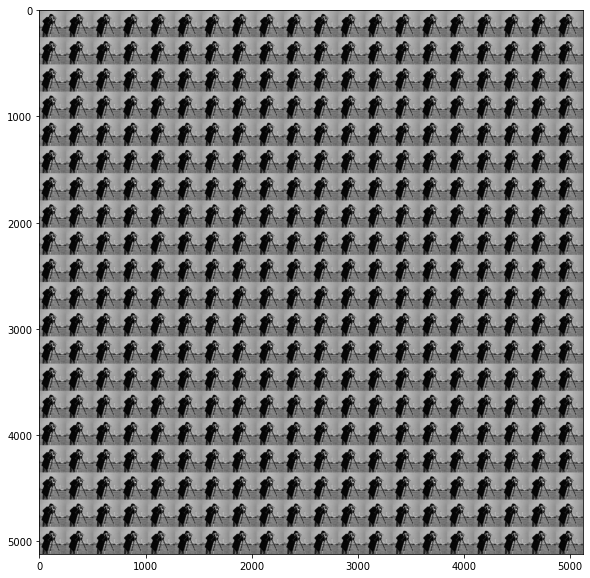

In [35]:
# Подготовим большую картинку
large_im = np.block([[im] * 20] * 20)
print(large_im.shape)
plt.figure(figsize=(10,10))
_ = plt.imshow(large_im, cmap="gray")

In [36]:
# Сформируем массивы для CPU (обычные numpy-массивы)...
large_X_np = im_to_array(np, large_im, BLOCK_SIZE, NUM_TPUS)
A_np = create_DCT2_matrix(np, BLOCK_SIZE)
Q_np = create_quantization_matrix(np, quality=50)
zigzag_idx_np = ZIGZAG_IDX

# ... и для TPU (jax-овский DeviceArray).
large_X_jnp = jnp.array(large_X_np)
A_jnp = jnp.array(A_np)
Q_jnp = jnp.array(Q_np)
zigzag_idx_jnp = jnp.array(ZIGZAG_IDX)

a. **(12 баллов)** Создайте 3 функции: `run_np`, `run_jax` и `run_pmap`. Они не должны принимать аргументов. Внутри они должны вызывать `compress_and_decompress_impl` с подготовленными аргументами-массивами. **Обратите внимание:** при запуске функций `run_jax` и `run_pmap` могут возникать JAX-специфичные ошибки. Поправьте код так, чтобы он работал как для `numpy`, так и для `jax.numpy`. Самые распространённые проблемы: 
1. Модификация массивов (присваивание вида `A[:, 5] = 10`) в JAX запрещена. Попробуйте использовать немодифицирующие операции
2. Индексация булевым массивом тоже не работает, вместо этого часто можно использовать, например, поэлементное умножение (`A * mask`).

Если не получается написать единообразно для `numpy` и `jax.numpy`, разрешается писать `if`-ы вида `if np == numpy: ....`.

**Полный балл выставляется, только если все три функции отрабатывают без ошибок.**

In [75]:
# compress_and_decompress_impl(np, X, A, Q, zigzag_idx):

def run_np():
    compress_and_decompress_impl(np, large_X_np, A_np, Q_np, zigzag_idx_np)

def run_jax():
    compress_and_decompress_impl(jnp, large_X_jnp, A_jnp, Q_jnp, zigzag_idx_jnp)

map_parallel = jax.pmap(lambda ITERMAT: compress_and_decompress_impl(
        jnp, ITERMAT, A_jnp, Q_jnp, zigzag_idx_jnp
    ),
    in_axes=(0))

def run_pmap():
    map_parallel(large_X_jnp)


Сравним время работы функций на большой картинке. 
Сделайте вывод об эффективности кода на CPU, на одном TPU и на 8-ми TPU.

In [76]:
%timeit run_np()

1 loop, best of 5: 2.38 s per loop


In [77]:
%timeit run_jax()

1 loop, best of 5: 282 ms per loop


*Уже заметно ускорение в 7-8 раз между первыми двумя функциями. Можно предположить, что с 8 TPU ускорение будет больше.*

In [78]:
%timeit run_pmap()

The slowest run took 29.40 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 35.2 ms per loop


*Так и вышло - получили ускорение в несколько десятков раз (60-70).*